In [1]:
MEAS_COLUMNS = [
    "TI-19",
#      "FI-16",
#     "TI-33",
#     "FI-2",
#     "FI-151",
#     "TI-8",
#     "FI-241",
#  "valve-position-12",  # dry-bed
#     "FI-38",  # strippera
#     "PI-28",  # stripper
    
#     "TI-28",  # stripper
#      "FI-20",
#     "FI-30",
    "TI-3",
    "FI-19",
#     "FI-211",
    "FI-11",
#     "TI-30",
#     "PI-30",
    "TI-1213",
#     "TI-4",
#    "FI-23",
#    "FI-20",
#   "FI-20/FI-23",
#    "TI-22",
#    "delta_t",
    "TI-35",
#     "delta_t_2"
]

TARGETS_clean = ['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2']

In [2]:
from functools import partial
from typing import List, Optional, Sequence

import numpy as np
import pandas as pd
import torch
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.logging import raise_if_not
from darts.models import TCNModel
from darts.utils import _build_tqdm_iterator

from joblib import Parallel, delayed
from torch.utils.data import DataLoader

from darts.metrics import mape, mae

[2022-01-11 23:11:42,975] WARNING | darts.models | Support for AutoARIMA is not available. To enable it, install u8darts[pmdarima] or u8darts[all].
[2022-01-11 23:11:42,975] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).


In [3]:
df = pd.read_pickle('../paper/20210624_df_cleaned.pkl')

In [95]:
y = TimeSeries.from_dataframe(df, value_cols=TARGETS_clean).astype(np.float32)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS).astype(np.float32)

In [96]:
transformer = Scaler()
x = transformer.fit_transform(x)

y_transformer = Scaler()
y = y_transformer.fit_transform(y)

In [97]:
def choose_index(series, fraction):
    timestamps = series.time_index
    fraction_index = int(len(timestamps) * fraction)

    return timestamps[fraction_index]


def split_data(x, y, targets, fraction_train, fraction_test=0.5):
    ts = choose_index(x, fraction_train)
    x_before, x_after = x.split_before(ts)
    y_before, y_after = y.split_before(ts)

    # ts_2 = choose_index(x_after, fraction_test)

    # x_valid, x_test = x_after.split_before(ts_2)
    # y_valid, y_test = y_after.split_before(ts_2)

    return ((x_before, y_before[targets]), (x_after, y_after[targets]))
    #     (x_test, y_test[targets]),
    # )


In [98]:
train, valid  = split_data(x, y, TARGETS_clean, 0.4)

In [99]:
len(valid[0])

3246

In [100]:
model_cov = TCNModel(
    input_chunk_length=20,
    output_chunk_length=10,
    num_layers=8,
    num_filters=32,
    kernel_size=4,
    dropout=0.3,
    weight_norm=True,
    batch_size=32,
    n_epochs=30,
    log_tensorboard=False,
    optimizer_kwargs={"lr": 1e-3},
)

In [101]:
model_cov.fit(series=train[1], past_covariates=train[0], verbose=False)

[2022-01-12 00:00:09,881] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2134 samples.
[2022-01-12 00:00:09,881] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2134 samples.
[2022-01-12 00:00:09,885] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-01-12 00:00:09,885] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.


In [102]:
backtest = model_cov.historical_forecasts(
    y,
    past_covariates=x,
    start=0.1,
    forecast_horizon=30,
    stride=1,
    retrain=False,
    verbose=False,
)

In [103]:
backtest

<TimeSeries (DataArray) (time: 4840, component: 2, sample: 1)>
array([[[0.2615086 ],
        [0.09992876]],

       [[0.2612094 ],
        [0.09997349]],

       [[0.2611427 ],
        [0.09992104]],

       ...,

       [[0.27545542],
        [0.11667233]],

       [[0.2751118 ],
        [0.11642803]],

       [[0.2747673 ],
        [0.11507201]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01T18:58:00 ... 2010-01-08T12:16:00
  * component  (component) <U1 '0' '1'
Dimensions without coordinates: sample

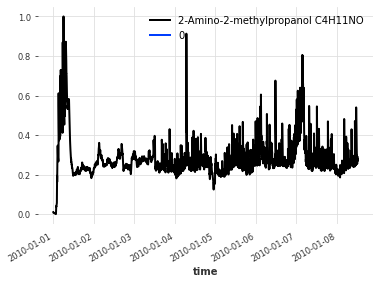

In [54]:

y[TARGETS_clean[0]].plot()
backtest['0'].plot()

In [23]:
mape(y[TARGETS_clean[0]], backtest['0'])

21.670974440116066

In [24]:
mae(y[TARGETS_clean[0]], backtest['0'])

0.058152869010724265

In [ ]:
Y = TimeSeries.from_dataframe(df, value_cols=TARGETS_clean)
X = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)


def get_data(num_outputs):
    x = X
    y = Y
    targets = TARGETS_clean if num_outputs == 1 else [TARGETS_clean[0]]
    print(targets)
    train, valid, test = split_data(x, y, targets, 0.5)

    return (train, valid, test)


def train_test():

    print("get data")
    train, valid, _ = get_data(1)

    print("initialize model")
    model_cov = TCNModel(
        input_chunk_length=60,
        output_chunk_length=30,
        num_layers=4,
        num_filters=32,
        kernel_size=4,
        dropout=0.3,
        weight_norm=True,
        batch_size=32,
        n_epochs=100,
        log_tensorboard=False,
        optimizer_kwargs={"lr": 1e-3},
    )

    print("fit")
    model_cov.fit(series=train[1], past_covariates=train[0], verbose=False)

    print("historical forecast train set")
    backtest_train = model_cov.historical_forecasts(
        train[1],
        past_covariates=train[0],
        start=0.1,
        forecast_horizon=30,
        stride=1,
        retrain=False,
        verbose=False,
    )

    print("historical forecast valid")
    backtest_valid = model_cov.historical_forecasts(
        valid[1],
        past_covariates=valid[0],
        start=0.1,
        forecast_horizon=30,
        stride=1,
        retrain=False,
        verbose=False,
    )

    print("getting scores")
    mape_valid = mape(valid[1][TARGETS_clean[0]], backtest_valid["0"])
    mape_train = mape(train[1][TARGETS_clean[0]], backtest_train["0"])

    mae_valid = mae(valid[1][TARGETS_clean[0]], backtest_valid["0"])
    mae_train = mae(train[1][TARGETS_clean[0]], backtest_train["0"])
    print(f"MAPE valid {mape_valid}")


In [105]:
train_test()

[2022-01-11 11:50:12,423] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2615 samples.
[2022-01-11 11:50:12,423] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 2615 samples.
[2022-01-11 11:50:12,427] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-11 11:50:12,427] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


get data
['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2']
initialize model
fit
historical forecast train set
historical forecast valid
getting scores
MAPE valid 467.9948294529864
